In [27]:
%run ../../common_utils.py

In [15]:
from catboost import CatBoostRegressor
import optuna
from optuna.samplers import TPESampler
from IPython.utils import io
import unidecode
from catboost import Pool

In [16]:
random_state = 1
number_of_splits = 5

In [17]:
def load_data(val_data=False,path=None,cat_unknown=False):
    train, test, metadata = load_all_data(path=path)
    nonCategorical, categorical = get_cat_and_non_cat_data(metadata)
    all_features = list(train.columns)
    all_features.remove('price')
    numerical_features = ['area_total','area_kitchen','area_living','floor','rooms','ceiling',
        'bathrooms_shared','bathrooms_private','balconies','loggias','phones','building_id','constructed','stories']
    categorical_to_numerical(train, ['street','address'])
    categorical_to_numerical(test, ['street','address'])
    if not val_data:
        X_train, y_train, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
                            outliers_value=7, val_data=val_data, val_split=0.2, random_state=42, scaler="std",
                            add_R="True", add_rel_height="True", droptable=[],
                            one_hot_encode=False, cat_features=categorical, drop_old=True,categorical_unknown=cat_unknown)
        y_train_log = np.log(y_train)
        return X_train, y_train, y_train_log, test_labels
    else:
        X_train, y_train, X_test, y_test, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
                            outliers_value=7, val_data=val_data, val_split=0.2, random_state=42, scaler="std",
                            add_R="True", add_rel_height="True", droptable=[],
                            one_hot_encode=False, cat_features=categorical, drop_old=True,categorical_unkown=cat_unknown)
        y_train_log = np.log(y_train)
        return X_train, y_train, y_train_log, X_test, y_test, test_labels

In [42]:
%%capture --no-display
X_train, y_train, y_train_log, test_labels = load_data(path='../',cat_unknown=True)
test_pd = test_labels.copy()
selected_features_catboost=['building_id','area_kitchen', 'area_living',
       'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private',
       'windows_court', 'windows_street', 'balconies', 'loggias', 'phones',
       'new', 'street', 'address', 'seller', 'layout', 'condition', 'district',
       'constructed', 'stories', 'elevator_without', 'elevator_passenger',
       'material', 'parking', 'heating', 'r', 'rel_height']

X_train = X_train[selected_features_catboost]
test_labels = test_labels[selected_features_catboost]
_, _, metadata = load_all_data(path='../')
_, categorical = get_cat_and_non_cat_data(metadata)
text_features=['street','address']
categorical.append('street')
categorical.append('address')
X_train = X_train.astype({'street':'int','address':'int','seller':'int','layout':'int','condition':'int','district':'int','material':'int','parking':'int','heating':'int'})
test_labels = test_labels.astype({'street':'int','address':'int','seller':'int','layout':'int','condition':'int','district':'int','material':'int','parking':'int','heating':'int'})

In [19]:
def objective(trial,X_train,y_train):
    
    param = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-1),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    scores = []
        
    cv = GroupKFold(n_splits=number_of_splits)
    groups = X_train["building_id"]
    i = 1
    for train_index, test_index in cv.split(X_train, y_train, groups):
        print("starting on split ",i)
        i+=1
        X_train2, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train2, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        X_train2.drop(['building_id'], axis=1,inplace=True)
        X_test.drop(['building_id'], axis=1,inplace=True)

        model = CatBoostRegressor(**param, random_state=random_state,loss_function='RMSE', cat_features=categorical)
        
        model.fit(
            X_train2,
            y_train2,
            eval_set=[(X_test, y_test)],
            verbose=False,
            early_stopping_rounds=100,
        )
        
        prediction = np.exp(model.predict(X_test))
        score = root_mean_squared_log_error(prediction, np.exp(y_test))
        scores.append(score)
    return np.average(scores)

In [20]:
study = optuna.create_study(sampler=TPESampler(), direction="minimize")
func = lambda trial: objective(trial, X_train, y_train_log)
study.optimize(func, n_trials=10, timeout=600) # Run for 10 minutes
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [21]:
study.optimize(func, n_trials=20

In [15]:
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of completed trials: 28
Best trial:
	Best Score: 0.2700280258709413
	Best Params: 
    learning_rate: 0.04493315459969882
    l2_leaf_reg: 0.1016956128187997
    colsample_bylevel: 0.09068864619114643
    depth: 8
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    min_data_in_leaf: 16
    one_hot_max_size: 5
    subsample: 0.708857568242697


In [22]:
study.optimize(func, n_trials=100)

In [17]:
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of completed trials: 128
Best trial:
	Best Score: 0.26552493946336475
	Best Params: 
    learning_rate: 0.0595682504013377
    l2_leaf_reg: 0.01619654653510247
    colsample_bylevel: 0.08580608350061232
    depth: 10
    boosting_type: Ordered
    bootstrap_type: MVS
    min_data_in_leaf: 18
    one_hot_max_size: 7


In [23]:
study.optimize(func, n_trials=100)

In [19]:
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of completed trials: 228
Best trial:
	Best Score: 0.26295902459609144
	Best Params: 
    learning_rate: 0.09983491174888588
    l2_leaf_reg: 0.013644264455059599
    colsample_bylevel: 0.09788222400849068
    depth: 8
    boosting_type: Ordered
    bootstrap_type: MVS
    min_data_in_leaf: 19
    one_hot_max_size: 7


In [24]:
study.optimize(func, n_trials=1000)

# Result from Optuna

Let's evaluate some of the results from Optuna. I've selected 5 trials to discuss the tuning, they are ordered by improving score:

Trial 449 finished with value: ```0.5542284052526306``` and parameters: ```{'learning_rate': 0.0009728418109572844, 'l2_leaf_reg': 0.30051036860892455, 'colsample_bylevel': 0.08816379281516293, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 9}.```

Trial 457 finished with value: ```0.26187749686179945``` and parameters: ```{'learning_rate': 0.058062306498398955, 'l2_leaf_reg': 0.36115004854385463, 'colsample_bylevel': 0.09228172758947267, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 11}.``` 

Trial 438 finished with value: ```0.26035104710375645``` and parameters: ```{'learning_rate': 0.07979622203930528, 'l2_leaf_reg': 0.4434173979295824, 'colsample_bylevel': 0.08605288211758522, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 11}.``` 

Trial 446 finished with value: ```0.26033042130942874``` and parameters:``` {'learning_rate': 0.07608938488623739, 'l2_leaf_reg': 0.36052283914139044, 'colsample_bylevel': 0.09183053727905705, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 10}.```

Trial 437 finished with value: ```0.2596557027450385``` and parameters: ```{'learning_rate': 0.0772446776104594, 'l2_leaf_reg': 0.5709519938247928, 'colsample_bylevel': 0.09221911838854839, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 11}.```


From this it is obvious that:
* decreasing the learning rate too much results in terrible performance
* Optimal learning rate should be searched around 0.07-0.08
* `bootstrap_type` `MVS` seems to be prefferred over both `Bernoulli` and `Bayesian`
* `boosting_type` `Plain` seems to be preffered
* `l2_leaf_reg`: typically around 0.36-0.44 but best score has 0.57
* `colsample_bylevel`: between 0.086-0.092
* `depth`: always 9
* `min_data_in_leaf`: 17 selected most often
* `one_hot_max_size`: 9-11


In [8]:
best_params = {
    'learning_rate': 0.0772446776104594, 
    'l2_leaf_reg': 0.5709519938247928, 
    'colsample_bylevel': 0.09221911838854839, 
    'depth': 9, 
    'boosting_type': 'Plain', 
    'bootstrap_type': 'MVS', 
    'min_data_in_leaf': 17, 
    'one_hot_max_size': 11}

In [10]:
model = CatBoostRegressor(**best_params, random_state=random_state,loss_function='RMSE', cat_features=categorical)

In [11]:
scores, average_score, best_model, best_index = catboost_groupKFold(number_of_splits, model, X_train, y_train_log, categorical_features=categorical,random_state=random_state)

starting on split  1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


starting on split  2
starting on split  3
starting on split  4
starting on split  5


In [12]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.2648731051281122, 0.25701082442561174, 0.24328323900871038, 0.2567346687002686, 0.2763766764624897]
average score:  0.2596557027450385
best model:     <catboost.core.CatBoostRegressor object at 0x000002199686BC40>
best index:     4


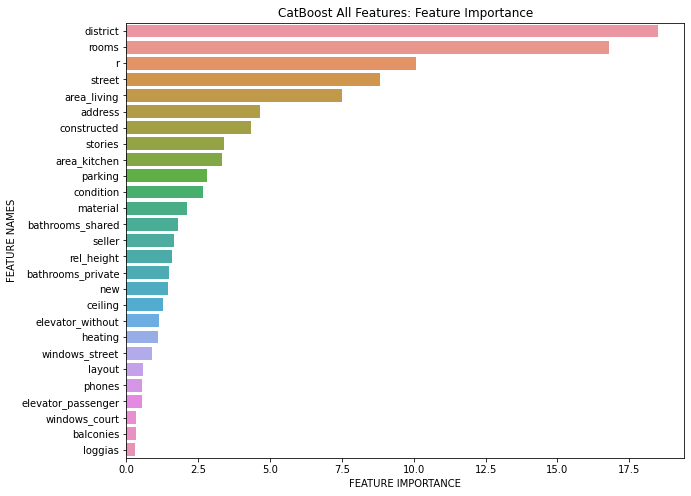

In [35]:
catboost_importance = model.get_feature_importance()
plot_feature_importance(catboost_importance, list(X_train.drop(['building_id'], axis=1).columns), 'CatBoost All Features: ')

Let's try an objective centered around the previous best found parameters

In [36]:
def improved_objective(trial,X_train,y_train):
    
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.06,0.09),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.3,0.6),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.08, 0.97),
        "depth": trial.suggest_int("depth", 8,10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 15,20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 8,12),  
    }
    scores = []
        
    cv = GroupKFold(n_splits=number_of_splits)
    groups = X_train["building_id"]
    i = 1
    for train_index, test_index in cv.split(X_train, y_train, groups):
        print("starting on split ",i)
        i+=1
        X_train2, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train2, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        X_train2.drop(['building_id'], axis=1,inplace=True)
        X_test.drop(['building_id'], axis=1,inplace=True)

        model = CatBoostRegressor(**param, random_state=random_state,loss_function='RMSE', cat_features=categorical)
        
        model.fit(
            X_train2,
            y_train2,
            eval_set=[(X_test, y_test)],
            verbose=False,
            early_stopping_rounds=100,
        )
        
        prediction = np.exp(model.predict(X_test))
        score = root_mean_squared_log_error(prediction, np.exp(y_test))
        scores.append(score)
    return np.average(scores)

In [52]:
study = optuna.create_study(sampler=TPESampler(), direction="minimize")
func = lambda trial: improved_objective(trial, X_train, y_train_log)
study.optimize(func, n_trials=10, timeout=600) # Run for 10 minutes
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-11-12 18:12:09,271] A new study created in memory with name: no-name-92935863-5acd-4863-bc4d-64436e1dad02


starting on split  1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

starting on split  2
starting on split  3
starting on split  4
starting on split  5


[I 2021-11-12 18:20:42,191] Trial 0 finished with value: 0.2660398829914937 and parameters: {'learning_rate': 0.08949242057972993, 'l2_leaf_reg': 0.512168134938264, 'colsample_bylevel': 0.41253876738467143, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 12}. Best is trial 0 with value: 0.2660398829914937.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


starting on split  1
starting on split  2
starting on split  3
starting on split  4
starting on split  5


[I 2021-11-12 18:28:23,371] Trial 1 finished with value: 0.2660220644134821 and parameters: {'learning_rate': 0.06876587468477545, 'l2_leaf_reg': 0.4718403554342223, 'colsample_bylevel': 0.3900045683816517, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 8}. Best is trial 1 with value: 0.2660220644134821.


Number of completed trials: 2
Best trial:
	Best Score: 0.2660220644134821
	Best Params: 
    learning_rate: 0.06876587468477545
    l2_leaf_reg: 0.4718403554342223
    colsample_bylevel: 0.3900045683816517
    depth: 10
    boosting_type: Plain
    bootstrap_type: MVS
    min_data_in_leaf: 16
    one_hot_max_size: 8
